autism_yes: clip range [0.019671, 0.218543]


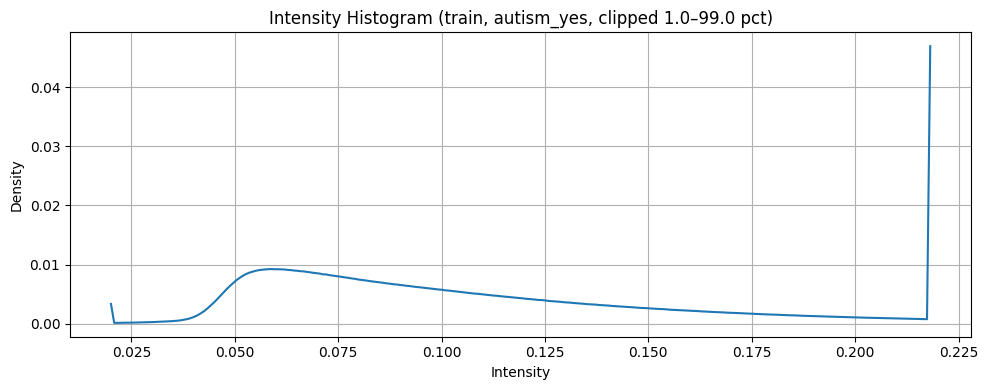

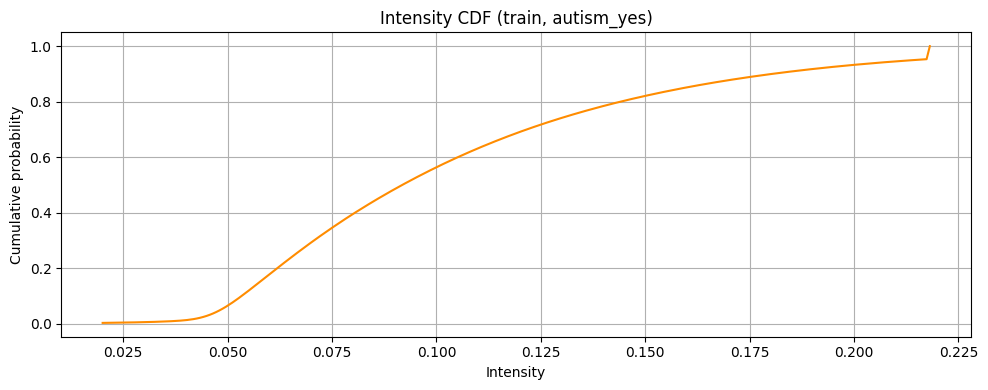

autism_yes approx stats (clipped):
  mean: 0.104540
  std:  0.048094
  voxels counted: 46358510
autism_no_new_nii: clip range [1.000000, 255.000000]


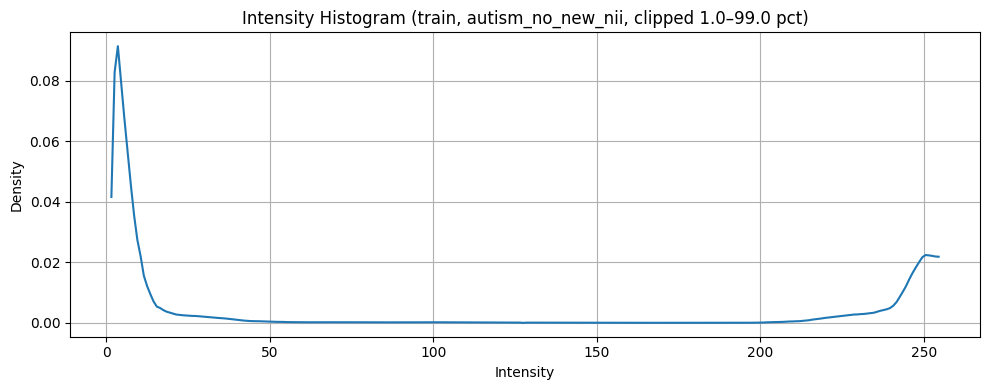

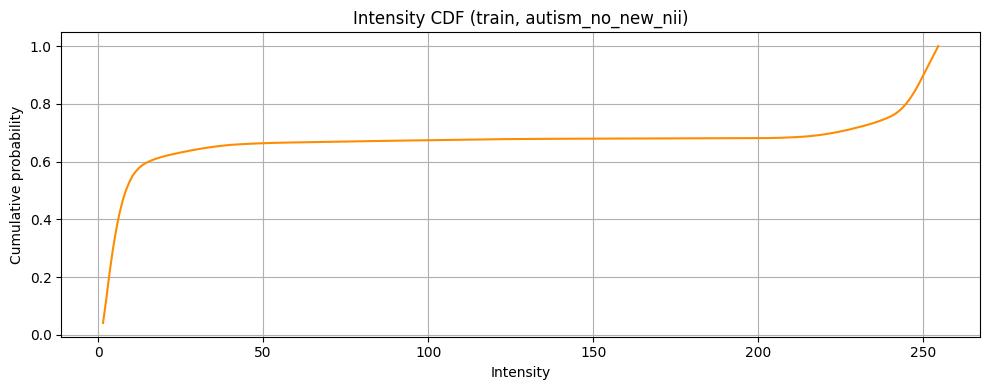

autism_no_new_nii approx stats (clipped):
  mean: 84.744990
  std:  110.214259
  voxels counted: 276346343


In [1]:
import os, glob
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

TRAIN_ROOT = "data_split/train"
CLASSES = ["autism_yes", "autism_no_new_nii"]
BINS = 256
CLIP_PCT = (1.0, 99.0)       # robust clipping
MAX_FILES_PER_CLASS = None   # e.g., 10 to limit for speed
MAX_SAMPLES_PER_CLASS = 1_000_000  # for estimating robust range

def find_files(folder):
    return sorted(glob.glob(os.path.join(folder, "*.nii")) +
                  glob.glob(os.path.join(folder, "*.nii.gz")))

def load_float32(path):
    img = nib.load(path)
    data = img.get_fdata(dtype=np.float32)  # halves memory vs float64
    if data.ndim == 4:
        data = data[..., 0]
    # mask background and non-finite
    data = data[np.isfinite(data) & (data > 0)]
    return data

def estimate_range(files, max_samples):
    samples = []
    budget = max_samples
    for fp in files:
        a = load_float32(fp)
        if a.size == 0:
            continue
        take = min(budget, a.size, 200_000)  # cap per file
        if take > 0:
            idx = np.random.choice(a.size, size=take, replace=False)
            samples.append(a[idx])
            budget -= take
        if budget <= 0:
            break
    if not samples:
        return 0.0, 1.0
    s = np.concatenate(samples)
    lo, hi = np.percentile(s, CLIP_PCT)
    if hi <= lo:
        lo, hi = float(np.min(s)), float(np.max(s))
    if hi == lo:
        hi = lo + 1.0
    return float(lo), float(hi)

for cls in CLASSES:
    cls_dir = os.path.join(TRAIN_ROOT, cls)
    files = find_files(cls_dir)
    if not files:
        print(f"[WARN] No files in {cls_dir}")
        continue
    if MAX_FILES_PER_CLASS:
        files = files[:MAX_FILES_PER_CLASS]

    # 1) Estimate robust range via sampling
    lo, hi = estimate_range(files, MAX_SAMPLES_PER_CLASS)
    print(f"{cls}: clip range [{lo:.6f}, {hi:.6f}]")

    # 2) Accumulate histogram counts without storing all voxels
    counts = np.zeros(BINS, dtype=np.int64)
    total_voxels = 0
    for fp in files:
        a = load_float32(fp)
        if a.size == 0:
            continue
        a = np.clip(a, lo, hi)
        c, edges = np.histogram(a, bins=BINS, range=(lo, hi))
        counts += c
        total_voxels += a.size

    if total_voxels == 0:
        print(f"[WARN] No voxels after masking for {cls}")
        continue

    # Plot histogram (density)
    bin_centers = (edges[:-1] + edges[1:]) / 2.0
    density = counts / counts.sum()
    plt.figure(figsize=(10,4))
    plt.plot(bin_centers, density, label=cls)
    plt.title(f"Intensity Histogram (train, {cls}, clipped {CLIP_PCT[0]}–{CLIP_PCT[1]} pct)")
    plt.xlabel("Intensity"); plt.ylabel("Density")
    plt.grid(True); plt.tight_layout(); plt.show()

    # Plot CDF
    cdf = np.cumsum(counts) / counts.sum()
    plt.figure(figsize=(10,4))
    plt.plot(bin_centers, cdf, label=cls, color="darkorange")
    plt.title(f"Intensity CDF (train, {cls})")
    plt.xlabel("Intensity"); plt.ylabel("Cumulative probability")
    plt.grid(True); plt.tight_layout(); plt.show()

    # Print summary stats (approx via clipped range and totals)
    approx_mean = (bin_centers * density).sum()
    approx_std = np.sqrt(((bin_centers - approx_mean)**2 * density).sum())
    print(f"{cls} approx stats (clipped):")
    print(f"  mean: {approx_mean:.6f}")
    print(f"  std:  {approx_std:.6f}")
    print(f"  voxels counted: {total_voxels}")

In [2]:
import os, glob
import numpy as np
import nibabel as nib

# Min–max normalization for training set (per volume)
TRAIN_IN = 'data_split/train'
TRAIN_OUT = 'data_split/train_minmax'
CLASSES = ['autism_yes', 'autism_no_new_nii']

os.makedirs(TRAIN_OUT, exist_ok=True)
for cls in CLASSES:
    src = os.path.join(TRAIN_IN, cls)
    dst = os.path.join(TRAIN_OUT, cls)
    os.makedirs(dst, exist_ok=True)

    files = sorted(glob.glob(os.path.join(src, '*.nii')) +
                   sorted(glob.glob(os.path.join(src, '*.nii.gz'))))
    if not files:
        print(f"[WARN] No files in {src}")
        continue

    for fp in files:
        try:
            img = nib.load(fp)
            data = img.get_fdata(dtype=np.float32)
            # Handle 4D by normalizing across all values (keeps shape intact)
            finite_mask = np.isfinite(data)
            pos_mask = (data > 0) & finite_mask
            mask = pos_mask if np.any(pos_mask) else finite_mask

            if not np.any(mask):
                norm = np.zeros_like(data, dtype=np.float32)
            else:
                dmin = float(data[mask].min())
                dmax = float(data[mask].max())
                if dmax <= dmin:
                    norm = np.zeros_like(data, dtype=np.float32)
                else:
                    norm = (data - dmin) / (dmax - dmin)
                    norm[~finite_mask] = 0.0

            # Save normalized volume
            hdr = img.header.copy()
            hdr.set_data_dtype(np.float32)
            nii = nib.Nifti1Image(norm.astype(np.float32), img.affine, header=hdr)
            out_path = os.path.join(dst, os.path.basename(fp))
            nib.save(nii, out_path)
            print(f"Saved: {out_path}")
        except Exception as e:
            print(f"[ERROR] {fp}: {e}")

print('Min–max normalization complete →', TRAIN_OUT)


Saved: data_split/train_minmax\autism_yes\CMU_a_0050649_reho.nii
Saved: data_split/train_minmax\autism_yes\CMU_a_0050653_reho.nii
Saved: data_split/train_minmax\autism_yes\CMU_b_0050651_reho.nii
Saved: data_split/train_minmax\autism_yes\CMU_b_0050657_reho.nii
Saved: data_split/train_minmax\autism_yes\Caltech_0051456_reho.nii
Saved: data_split/train_minmax\autism_yes\Caltech_0051459_reho.nii
Saved: data_split/train_minmax\autism_yes\Caltech_0051460_reho.nii
Saved: data_split/train_minmax\autism_yes\Caltech_0051462_reho.nii
Saved: data_split/train_minmax\autism_yes\Caltech_0051463_reho.nii
Saved: data_split/train_minmax\autism_yes\Caltech_0051464_reho.nii
Saved: data_split/train_minmax\autism_yes\Caltech_0051467_reho.nii
Saved: data_split/train_minmax\autism_yes\Caltech_0051469_reho.nii
Saved: data_split/train_minmax\autism_yes\Caltech_0051470_reho.nii
Saved: data_split/train_minmax\autism_yes\Caltech_0051471_reho.nii
Saved: data_split/train_minmax\autism_yes\Caltech_0051472_reho.nii
Sav

autism_yes: clip range [0.057637, 0.702877]


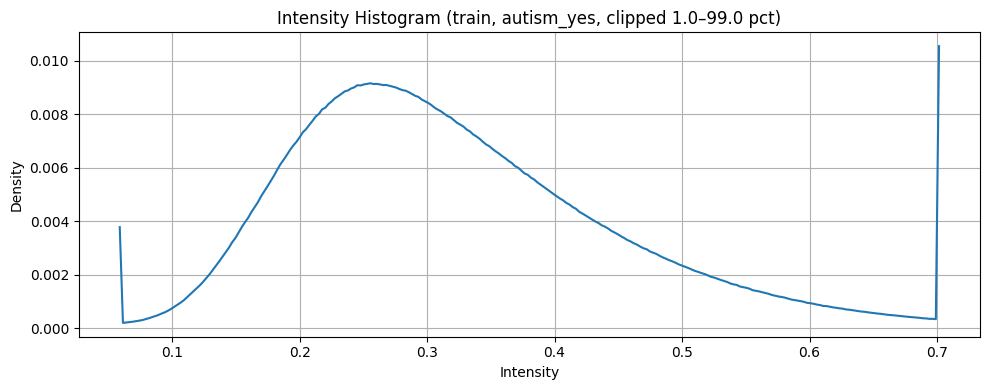

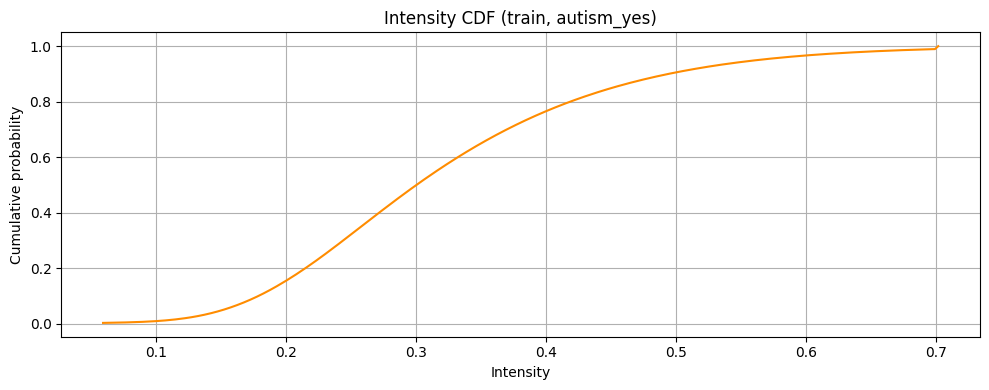

autism_yes approx stats (clipped):
  mean: 0.321414
  std:  0.125329
  voxels counted: 46357805
autism_no_new_nii: clip range [0.003937, 1.000000]


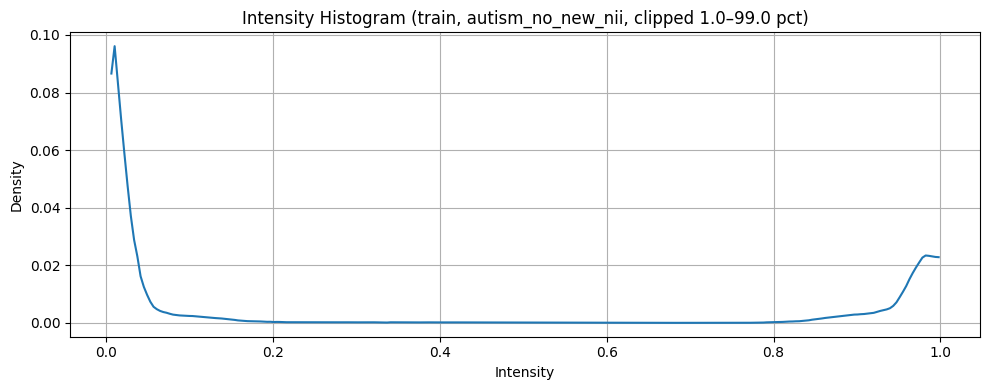

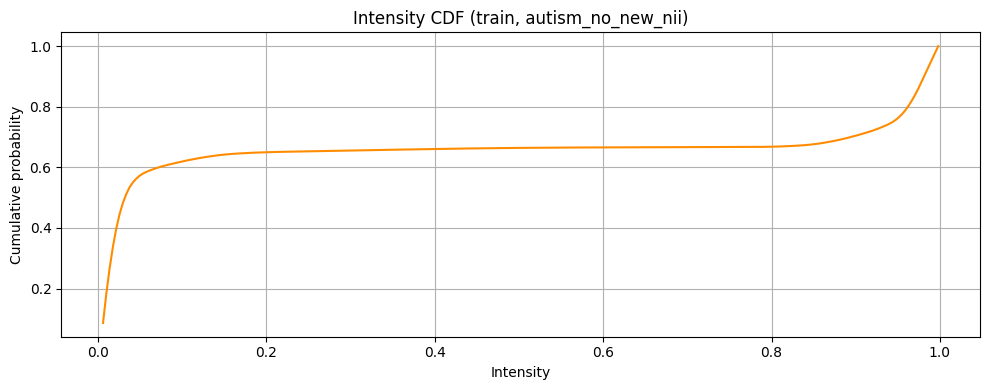

autism_no_new_nii approx stats (clipped):
  mean: 0.344036
  std:  0.437873
  voxels counted: 264840952


In [3]:
import os, glob
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

TRAIN_ROOT = "data_split/train_minmax"
CLASSES = ["autism_yes", "autism_no_new_nii"]
BINS = 256
CLIP_PCT = (1.0, 99.0)       # robust clipping
MAX_FILES_PER_CLASS = None   # e.g., 10 to limit for speed
MAX_SAMPLES_PER_CLASS = 1_000_000  # for estimating robust range

def find_files(folder):
    return sorted(glob.glob(os.path.join(folder, "*.nii")) +
                  glob.glob(os.path.join(folder, "*.nii.gz")))

def load_float32(path):
    img = nib.load(path)
    data = img.get_fdata(dtype=np.float32)  # halves memory vs float64
    if data.ndim == 4:
        data = data[..., 0]
    # mask background and non-finite
    data = data[np.isfinite(data) & (data > 0)]
    return data

def estimate_range(files, max_samples):
    samples = []
    budget = max_samples
    for fp in files:
        a = load_float32(fp)
        if a.size == 0:
            continue
        take = min(budget, a.size, 200_000)  # cap per file
        if take > 0:
            idx = np.random.choice(a.size, size=take, replace=False)
            samples.append(a[idx])
            budget -= take
        if budget <= 0:
            break
    if not samples:
        return 0.0, 1.0
    s = np.concatenate(samples)
    lo, hi = np.percentile(s, CLIP_PCT)
    if hi <= lo:
        lo, hi = float(np.min(s)), float(np.max(s))
    if hi == lo:
        hi = lo + 1.0
    return float(lo), float(hi)

for cls in CLASSES:
    cls_dir = os.path.join(TRAIN_ROOT, cls)
    files = find_files(cls_dir)
    if not files:
        print(f"[WARN] No files in {cls_dir}")
        continue
    if MAX_FILES_PER_CLASS:
        files = files[:MAX_FILES_PER_CLASS]

    # 1) Estimate robust range via sampling
    lo, hi = estimate_range(files, MAX_SAMPLES_PER_CLASS)
    print(f"{cls}: clip range [{lo:.6f}, {hi:.6f}]")

    # 2) Accumulate histogram counts without storing all voxels
    counts = np.zeros(BINS, dtype=np.int64)
    total_voxels = 0
    for fp in files:
        a = load_float32(fp)
        if a.size == 0:
            continue
        a = np.clip(a, lo, hi)
        c, edges = np.histogram(a, bins=BINS, range=(lo, hi))
        counts += c
        total_voxels += a.size

    if total_voxels == 0:
        print(f"[WARN] No voxels after masking for {cls}")
        continue

    # Plot histogram (density)
    bin_centers = (edges[:-1] + edges[1:]) / 2.0
    density = counts / counts.sum()
    plt.figure(figsize=(10,4))
    plt.plot(bin_centers, density, label=cls)
    plt.title(f"Intensity Histogram (train, {cls}, clipped {CLIP_PCT[0]}–{CLIP_PCT[1]} pct)")
    plt.xlabel("Intensity"); plt.ylabel("Density")
    plt.grid(True); plt.tight_layout(); plt.show()

    # Plot CDF
    cdf = np.cumsum(counts) / counts.sum()
    plt.figure(figsize=(10,4))
    plt.plot(bin_centers, cdf, label=cls, color="darkorange")
    plt.title(f"Intensity CDF (train, {cls})")
    plt.xlabel("Intensity"); plt.ylabel("Cumulative probability")
    plt.grid(True); plt.tight_layout(); plt.show()

    # Print summary stats (approx via clipped range and totals)
    approx_mean = (bin_centers * density).sum()
    approx_std = np.sqrt(((bin_centers - approx_mean)**2 * density).sum())
    print(f"{cls} approx stats (clipped):")
    print(f"  mean: {approx_mean:.6f}")
    print(f"  std:  {approx_std:.6f}")
    print(f"  voxels counted: {total_voxels}")

In [1]:
import os
import numpy as np
import nibabel as nib
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
TARGET_SHAPE = (64, 128, 128)  # D, H, W
BATCH_SIZE = 2
EPOCHS = 50

In [3]:
# Feed pre-processed .nii/.nii.gz training volumes to a 3D CNN (TensorFlow/Keras)
# Assumes folder structure with class subfolders, e.g.:
#   data_split/train/autism_no_new_nii/*.nii.gz  -> label 0
#   data_split/train/autism_yes/*.nii.gz         -> label 1
# Optionally a validation set at:
#   data_split/test/<same subfolders>

import os, glob
from typing import Tuple, Optional, List
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks

# -----------------------------
# Minimal 3D CNN
# -----------------------------
def _conv3d_block(
    x: tf.Tensor,
    filters: int,
    kernel_size: Tuple[int, int, int] = (3, 3, 3),
    strides: Tuple[int, int, int] = (1, 1, 1),
    padding: str = "same",
    use_bias: bool = False,
    name: Optional[str] = None,
) -> tf.Tensor:
    x = layers.Conv3D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias,
                      name=None if name is None else f"{name}_conv")(x)
    x = layers.BatchNormalization(name=None if name is None else f"{name}_bn")(x)
    x = layers.Activation("relu", name=None if name is None else f"{name}_relu")(x)
    return x

def build_brain_mri_3dcnn_tf(
    input_shape: Tuple[int, int, int, int],  # (D, H, W, C)
    num_classes: int = 2,
    width_multiplier: float = 1.0,
    dropout_rate: float = 0.3,
    classifier_activation: Optional[str] = None,  # None => logits
) -> Model:
    def f(ch: int) -> int:
        return max(8, int(ch * width_multiplier))

    inputs = layers.Input(shape=input_shape)

    x = _conv3d_block(inputs, f(32), name="stem")

    x = _conv3d_block(x, f(32), name="b1_c1")
    x = _conv3d_block(x, f(64), name="b1_c2")
    x = layers.MaxPool3D(pool_size=2, strides=2, name="b1_pool")(x)

    x = _conv3d_block(x, f(64), name="b2_c1")
    x = _conv3d_block(x, f(128), name="b2_c2")
    x = layers.MaxPool3D(pool_size=2, strides=2, name="b2_pool")(x)

    x = _conv3d_block(x, f(128), name="b3_c1")
    x = _conv3d_block(x, f(256), name="b3_c2")
    x = layers.MaxPool3D(pool_size=2, strides=2, name="b3_pool")(x)

    x = _conv3d_block(x, f(256), name="b4_c1")
    x = _conv3d_block(x, f(512), name="b4_c2")
    x = layers.MaxPool3D(pool_size=2, strides=2, name="b4_pool")(x)

    x = layers.GlobalAveragePooling3D(name="gap")(x)
    x = layers.Dropout(rate=dropout_rate, name="dropout")(x)
    outputs = layers.Dense(num_classes, activation=classifier_activation, name="classifier")(x)
    return Model(inputs, outputs, name="BrainMRI3DCNN_TF")

# -----------------------------
# Data: load pre-processed NIfTI volumes as-is
# -----------------------------
def py_load_nifti(path_str: bytes) -> np.ndarray:
    path = path_str.decode("utf-8")
    vol = nib.load(path).get_fdata(dtype=np.float32)  # pre-processed already
    if vol.ndim != 3:
        raise ValueError(f"Expected 3D volume, got shape {vol.shape} for {path}")
    vol = np.expand_dims(vol, axis=-1).astype(np.float32)  # (D,H,W,1) channels-last
    return vol

def make_dataset_from_folders(
    root_dir: str,
    class_names: List[str],
    batch_size: int = 1,
    shuffle: bool = True,
) -> Tuple[tf.data.Dataset, List[str], List[int]]:
    filepaths, labels = [], []
    for label, cname in enumerate(class_names):
        pattern = os.path.join(root_dir, cname, "*.nii*")
        files = sorted(glob.glob(pattern))
        filepaths.extend(files)
        labels.extend([label] * len(files))

    if len(filepaths) == 0:
        raise RuntimeError(f"No NIfTI files found under {root_dir} with class folders {class_names}")

    ds_paths = tf.constant(filepaths)
    ds_labels = tf.constant(labels, dtype=tf.int32)
    ds = tf.data.Dataset.from_tensor_slices((ds_paths, ds_labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(filepaths), reshuffle_each_iteration=True)

    def _loader(path, y):
        vol = tf.numpy_function(py_load_nifti, [path], tf.float32)
        # Set static shape after first sample inference
        vol.set_shape(INPUT_SHAPE)
        return vol, y

    ds = ds.map(_loader, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds, filepaths, labels

# -----------------------------
# Configure paths
# -----------------------------
train_dir = "data_split/train"
val_dir = "data_split/test"  # optional; comment out if you only have training
class_names = ["autism_no_new_nii", "autism_yes"]  # adjust to your folders

# Infer input shape from a sample (D,H,W,1)
sample_glob = os.path.join(train_dir, class_names[0], "*.nii*")
sample_path = sorted(glob.glob(sample_glob))[0]
sample_vol = nib.load(sample_path).get_fdata(dtype=np.float32)
INPUT_SHAPE = tuple(sample_vol.shape) + (1,)  # e.g., (96,96,96,1)

# -----------------------------
# Build datasets
# -----------------------------
BATCH_SIZE = 1  # increase if memory allows
train_ds, train_paths, _ = make_dataset_from_folders(train_dir, class_names, batch_size=BATCH_SIZE, shuffle=True)

# Optional validation set
if os.path.isdir(val_dir):
    val_ds, _, _ = make_dataset_from_folders(val_dir, class_names, batch_size=BATCH_SIZE, shuffle=False)
else:
    val_ds = None

# -----------------------------
# Model, loss, metrics, training
# -----------------------------
model = build_brain_mri_3dcnn_tf(input_shape=INPUT_SHAPE, num_classes=len(class_names))

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(name="acc"),
    tf.keras.metrics.AUC(name="auc"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=loss_fn, metrics=metrics)
model.summary(line_length=120)

es = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

if val_ds is not None:
    history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[es], verbose=1)
else:
    # If no validation set, train without EarlyStopping
    history = model.fit(train_ds, epochs=50, verbose=1)


ValueError: Exception encountered when calling layer "b1_pool" (type MaxPooling3D).

Negative dimension size caused by subtracting 2 from 1 for '{{node b1_pool/MaxPool3D}} = MaxPool3D[T=DT_FLOAT, data_format="NDHWC", ksize=[1, 2, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 2, 1]](Placeholder)' with input shapes: [?,630,630,1,64].

Call arguments received by layer "b1_pool" (type MaxPooling3D):
  • inputs=tf.Tensor(shape=(None, 630, 630, 1, 64), dtype=float32)